# TP1: Classifieur linéaire, fonction de perte **Hinge** de type **one-vs-one**

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)
    X_batch -= np.mean(X_batch, axis = 0)

    # Ajout du biais
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    X_batch = np.hstack([X_batch, np.ones((X_batch.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)


## Classifieur linéaire avec fonction de perte de type "Hinge loss"

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `hinge_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  

**NOTE IMPORTANTE**: les solutions que vous devez obtenir proviennent d'une implantation de type **one-vs-one** de la fonction *Hinge*.  Si nous aviez à coder une solution **one-vs-all** (également appelée *one-vs-rest*) vous devriez obtenir une loss de 8.63 (au lieu de 1.28) pour la cellule suivante et 9.09 (au lieu de 1.53) pour la cellule d'après.


In [4]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction hinge_naive_forward_backward située dans le fichier           #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import hinge_naive_forward_backward

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.28220758164
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [5]:
##############################################################################
# TODO: Même chose qu'à la cellule précédente mais...                        #
#   vec N=500 images et autant de cibles                                     #
##############################################################################

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 1.53644079
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 1:
   
Expliquez pourquoi lorsque la matrice de poids W est initialisée avec des valeurs proches de zéro, la **hinge loss** tend vers 1.0.

**Réponse :** La hinge loss tend vers 1, car pour des poids initialisés avec des valeurs proches de zéro, la différence entre le score de la classe prédite et celui de la classe cible sera faible, à savoir comprise entre -1 et 1. Donc, étant donné le calcul de la hinge loss, moins il y a d'erreurs de prédiction, plus la loss tendra vers 1 (car la différence des scores tendra vers 0). 

## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [6]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       hinge_naive_forward_backward située dans le fichier utils.loss       #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.011288303265
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([0.0, 1.28672636, 0.0])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [7]:
##############################################################################
# TODO:                                                                      #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.5373299967
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-2.395425, -0.840625, -0.32925, 7.256375])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de la hinge loss (et de son gradient) via la fonction *hinge_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le test du **gradient numérique**

In [8]:
##############################################################################
# En principe, le fait d'augmenter le terme de régularisation L2 devrait     #
# augmenter la loss...                                                       #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.5
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


1.5727089540922048
1.5803789662224894
1.5918839844179162
1.6091415117110566
1.6350278026507672
1.673857239060333
1.7321013936746819
1.819467625596205
1.9505169734784897
2.147090995301917
Bravo!


In [9]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: 0.990904, analytic 0.990904, relative error: 1.859817e-10
numerical: 1.183576, analytic 1.183576, relative error: 6.065640e-12
numerical: -2.454640, analytic -2.454640, relative error: 1.486714e-11
numerical: 0.396608, analytic 0.396608, relative error: 3.403244e-12
numerical: -1.789536, analytic -1.789536, relative error: 1.075714e-10
numerical: -5.888000, analytic -5.888000, relative error: 8.626403e-12
numerical: 0.029672, analytic 0.029672, relative error: 5.363237e-10
numerical: -4.580000, analytic -4.580000, relative error: 3.469132e-12
numerical: 0.634432, analytic 0.634432, relative error: 3.864028e-10
numerical: 0.328456, analytic 0.328456, relative error: 4.081849e-10

------------
Gradient check : reg=1e-2
------------

numerical: 2.268760, analytic 2.353584, relative error: 1.835086e-02
numerical: 0.193467, analytic 0.262744, relative error: 1.518534e-01
numerical: 4.469035, analytic 4.481112, relative error: 1.3

## Hinge loss et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **hinge_naive_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

### Question 2:  
Les prochaines étapes consistent à implanter le calcul de la loss et du gradient de la loss de façon **linéarisée**.  Avant de commencer à coder, veuillez donner ici la formule de la loss et du gradient pour une mini-batch de 500 données contenue dans le tableau 

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = ....$$

$$dW = ....$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et ventorielles.  De plus, la solution ayant au plus 15 lignes en Python, inutile de complexifiée inutilement la réponse.  En d'autres mots, on attend une réponse de quelques lignes (et non quelques pages!). 

In [10]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction hinge_naive_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
import time

start = time.time()
loss_naive, grad_naive = hinge_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import hinge_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = hinge_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 1.557369e+00 computed in 0.047000s
vectorized loss: 1.557369e+00 computed in 0.038001s
bravo pour la loss!
Loss difference: 0.000000
bravo pour le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** (dans *model/LinearClassifier.py*) ainsi que de la fonction vectorisée **hinge_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

loss :  5.645494524758132
loss :  3.432523782804777
loss :  2.87590550946189
loss :  2.775355365535781
loss :  2.281819137680815
loss :  2.4525126615359922
loss :  2.3993409992989756
loss :  2.359719760836609
loss :  2.247349071038538
loss :  2.2815604721658875
train vs val acc 0.255755 / 0.274000


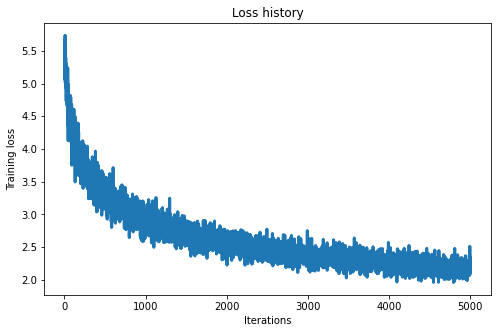

In [11]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 100

classifier = LinearClassifier(hinge_forward_backward)
# #
# # TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
# #
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=5000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

loss :  5.665189280111395
loss :  4.6292815573452035
loss :  4.805678983244662
loss :  4.260966023947143
loss :  3.986935563427957
loss :  3.8830571858747818
loss :  6.899839170800496
loss :  5.616806966068632
loss :  5.151786605665604
loss :  5.166232617868538
loss :  5.777760843944528
loss :  5.2204662568461
loss :  5.339941385251027
loss :  5.283447474547257
loss :  5.189589823719862
loss :  5.120103090740357
loss :  5.3728876676230195
loss :  5.576204809769329
loss :  5.511722007818671
loss :  5.145976887615675
loss :  5.451293708638893
loss :  5.343612266993548
loss :  5.370398563046856
loss :  5.4473638860755
loss :  5.50206403171751
loss :  5.458749879731417
loss :  5.065406313623888
loss :  5.236907144401885
loss :  5.2013169502202325
loss :  5.509735982669425
loss :  5.176019358963924
loss :  5.818051415827931
loss :  4.8596029193494
loss :  5.4114472241484055
loss :  5.502372750901539
loss :  5.241295431189262
loss :  5.116332794822856
loss :  5.382683327918638
loss :  5.3831

loss :  3.6334933877776425
loss :  3.651632113121953
loss :  3.7760854107633257
loss :  3.4307880711473047
loss :  3.7957079302698777
loss :  3.5993696972937546
loss :  3.7964014460557105
loss :  3.5576606597646627
loss :  3.6605365386753954
loss :  3.5556228477574057
loss :  3.4224609343747465
loss :  3.9898395918404983
loss :  3.708122637983102
loss :  3.553187126660058
loss :  3.6243374784603066
loss :  3.857204173678883
loss :  3.538190299621623
loss :  3.6537640345931988
loss :  3.781983795741062
loss :  3.664431934073397
loss :  3.7724627549836587
loss :  3.546642725704395
loss :  3.6456188229070348
loss :  3.8255239133637167
loss :  3.6191000655192194
loss :  3.83186953798331
loss :  3.7187800158118343
loss :  3.875578104846835
loss :  3.743827597911815
loss :  3.6000019926995956
loss :  3.3788533039492927
loss :  3.6821696077662747
loss :  3.526528793946731
loss :  3.501297240079288
loss :  3.716586464646663
loss :  3.6613521244294973
loss :  3.496961332204247
loss :  3.7477158

loss :  1.8612243455885227
loss :  1.952828528202018
loss :  1.797397306467499
loss :  1.786754916010937
loss :  1.8171032106529443
loss :  1.8138452931278053
loss :  1.6949611499333133
loss :  1.7781640092578848
loss :  1.8531167889243931
loss :  1.8572288358561126
loss :  1.7910718511853245
loss :  1.9498333869566238
loss :  1.9902372469674179
loss :  1.7895678102133883
loss :  1.9065441292827705
loss :  1.9801896887446981
loss :  1.8111241612283542
loss :  1.7565321510955645
loss :  1.9593135182663914
loss :  1.8640746052062902
loss :  1.9019954840784283
loss :  1.8264277689957773
loss :  1.870807556551873
loss :  1.947033874008252
loss :  1.888863937314801
loss :  1.829148229491483
loss :  1.8737159201300528
loss :  1.8416055235152289
loss :  1.8722977202403743
loss :  1.9123286631468936
loss :  1.8835784414855494
loss :  1.7816755972295608
loss :  1.9071604496223709
loss :  1.9051662216327052
loss :  1.9155208133603607
loss :  1.8192816891541261
loss :  1.8862807348775545
loss :  

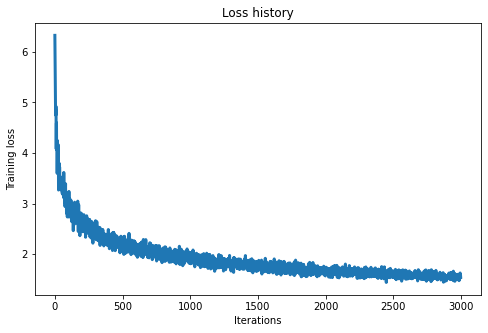

In [12]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_reg = -1
best_lr = -1
learning_rates = np.linspace(1e-8, 1e-6, 5)
regularization_strengths = np.linspace(1, 1e3, 3)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 3000    #
#  vous devriez obtenir une précision de classification supérieur à 0.30 sur #
#  l'ensemble de validation, et de 0.36 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        classifier = LinearClassifier(hinge_forward_backward)
        train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000, verbose = True)
        y_val_pred = classifier.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        if(acc_val > best_val):
            best_val = acc_val
            best_reg = reg
            best_lr = lr
            best_loss_history = train_loss_history
            best_classifier = classifier

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [13]:
# En réentraine avec plus d'itérations
classifier = LinearClassifier(hinge_forward_backward)
train_loss_history = classifier.train(X_train, y_train, learning_rate=best_lr, reg=best_reg, num_iter=6000, verbose = True)

# On évalue la performance sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Linear model with Hinge loss : CIFAR-10 final test accuracy: %f' % (test_accuracy) )

loss :  6.548656030982909
loss :  2.2054169161397006
loss :  1.858643165288433
loss :  1.8105541185889984
loss :  1.6434518850509536
loss :  1.5847747685306068
loss :  1.6288895775824144
loss :  1.5666876254302842
loss :  1.5707771820428718
loss :  1.5484123085248398
loss :  1.6324507568828788
loss :  1.568448488441442
loss :  1.611147498203816
loss :  1.6140526473197305
loss :  1.648356125545297
loss :  1.6209462327362758
loss :  1.6016474043694593
loss :  1.5269264656581465
loss :  1.5814775673542465
loss :  1.5304420328950703
loss :  1.5778142107391195
loss :  1.5943762476259724
loss :  1.5491511036864345
loss :  1.6397315687526792
loss :  1.5606147171021212
loss :  1.5694662429324888
loss :  1.6175064833077033
loss :  1.5274672016230633
loss :  1.6347098557335857
loss :  1.5612958611642638
loss :  1.584854584052003
loss :  1.6110674665734945
loss :  1.5452620673808866
loss :  1.6241293609367948
loss :  1.6451198295628657
loss :  1.6113571844742314
loss :  1.5860949867736793
loss : 

loss :  1.4067816121980974
loss :  1.3904904925252786
loss :  1.3522476373868293
loss :  1.3664953512021547
loss :  1.3875258866653235
loss :  1.3865459764691068
loss :  1.3931023608834079
loss :  1.3864247572266573
loss :  1.4103905912605945
loss :  1.354658515408602
loss :  1.358624781676441
loss :  1.412837660934704
loss :  1.3350460829217385
loss :  1.3604995401245836
loss :  1.3783998337835528
loss :  1.3843543554968643
loss :  1.3668039571668484
loss :  1.307856569932283
loss :  1.391362213822789
loss :  1.3573621315376738
loss :  1.4089396432185595
loss :  1.4134371436645432
loss :  1.3577222949311893
loss :  1.443210354871402
loss :  1.3582989740899192
loss :  1.3963967957249372
loss :  1.4080455011632438
loss :  1.3527098072848955
loss :  1.367530750897156
loss :  1.340647773957075
loss :  1.3568226071920202
loss :  1.3764310670471036
loss :  1.390275674104705
loss :  1.4014873137139545
loss :  1.3477722601533906
loss :  1.386304338952148
loss :  1.3967502405907952
loss :  1.4

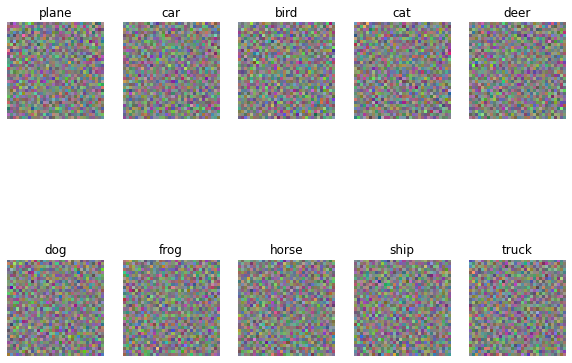

In [14]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])